In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
matplotlib.rcParams['axes.titlesize'] = 18

Before we ge started, if you haven't looked at the pyspark script used to create this data, here a few important things to note:
* I creating it by grouping the raw rate data by state and age, computing the average rate for each of those groups, and then computing the percentage change for those groups from year to year.
* You'll notice that columns pertaining to family rates are NA except for when Age == 'Family Option'. This is correct.

Let's import the data and get an get an idea of what it looks like.

In [239]:
change1415 = pd.read_csv('change1415.csv')
change1516 = pd.read_csv('change1516.csv')
change1617 = pd.read_csv('change1617.csv')
change1415.head()

,StateCode,Age,avg(IndividualRate)_2014,avg(IndividualTobaccoRate)_2014,avg(Couple)_2014,avg(PrimarySubscriberAndOneDependent)_2014,avg(PrimarySubscriberAndTwoDependents)_2014,avg(PrimarySubscriberAndThreeOrMoreDependents)_2014,avg(CoupleAndOneDependent)_2014,avg(CoupleAndTwoDependents)_2014,...,avg(CoupleAndThreeOrMoreDependents)_2015,change_avg(IndividualRate),change_avg(IndividualTobaccoRate),change_avg(Couple),change_avg(PrimarySubscriberAndOneDependent),change_avg(PrimarySubscriberAndTwoDependents),change_avg(PrimarySubscriberAndThreeOrMoreDependents),change_avg(CoupleAndOneDependent),change_avg(CoupleAndTwoDependents),change_avg(CoupleAndThreeOrMoreDependents)
0,SC,Family Option,26.568579,NaN,45.970598,45.162818,63.757422,87.464759,64.564371,83.159076,...,112.351739,23.154725,NaN,14.603655,15.627532,23.381819,9.671423,22.557723,14.351529,5.133149
1,TX,29,188.201377,314.890420,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.735783,-6.384138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WI,42,388.225208,478.267213,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.484193,-3.680138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IN,62,799.026427,1332.284679,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-55.742872,-25.436129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PA,26,229.106052,280.519724,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-9.239450,-0.988973,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It'll be difficult to work with some of the column names, so let's get rid of the parentheses and 'avg' in the change columns.

In [250]:
import re
toMatch = re.compile('\(\w+\)')
renameCols = {col:  col.replace('(', "").replace(')', "").replace('avg', "") for col in change1415.columns  if 'change' in col}
change1415 = change1415.rename(columns=renameCols)
change1516 = change1516.rename(columns=renameCols)
change1617 = change1617.rename(columns=renameCols)

## Individual Rates By Age

Let's first examine how rates for individuals have changed. We'll start by averaging the change in rates for each age category across all of the states. Then we'll plot them. 

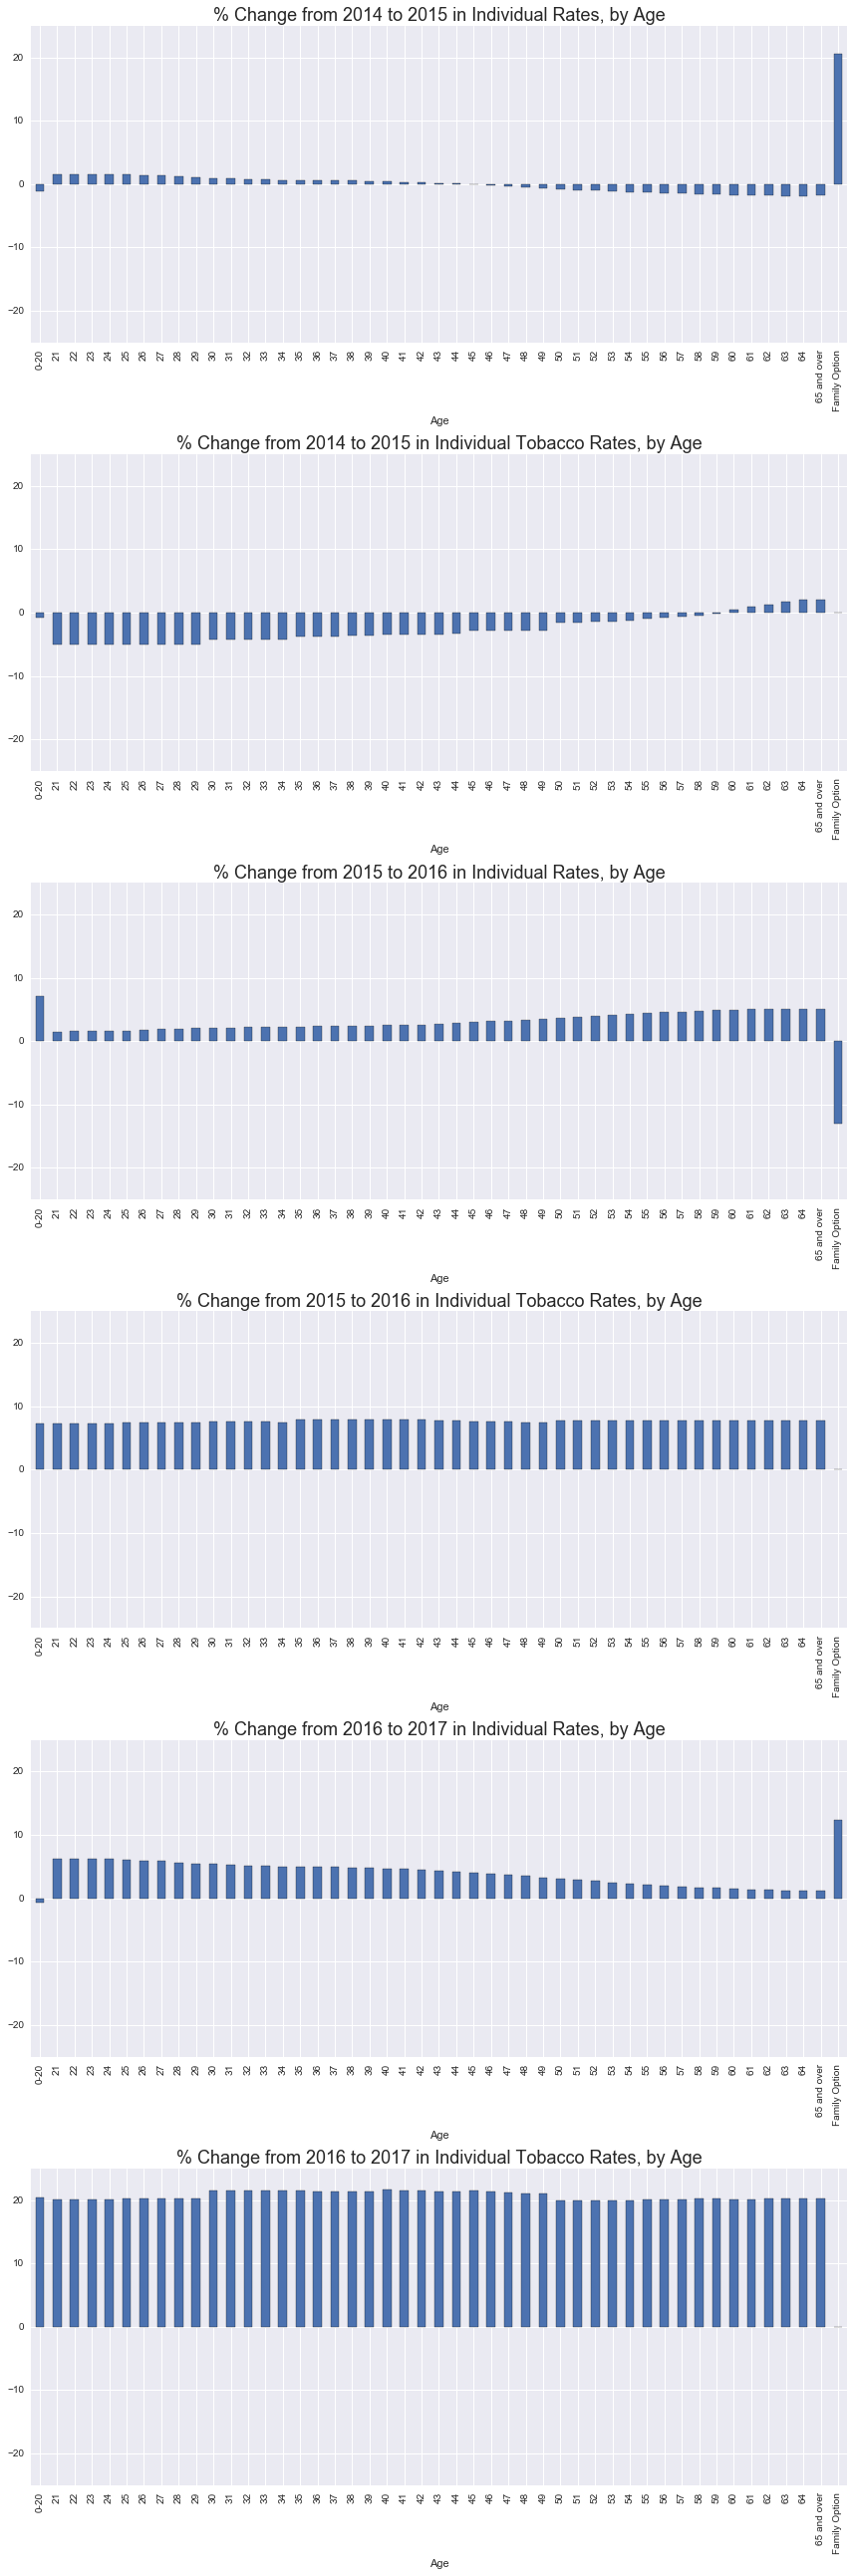

In [255]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=(12,36))

change1415.groupby(['Age'])['change_IndividualRate'].mean().plot.bar(ax=ax1)
ax1.set_title('% Change from 2014 to 2015 in Individual Rates, by Age')
ax1.set_ylim((-25,25))

change1415.groupby(['Age'])['change_IndividualTobaccoRate'].mean().plot.bar(ax=ax2)
ax2.set_title('% Change from 2014 to 2015 in Individual Tobacco Rates, by Age')
ax2.set_ylim((-25,25))

change1516.groupby(['Age'])['change_IndividualRate'].mean().plot.bar(ax=ax3)
ax3.set_title('% Change from 2015 to 2016 in Individual Rates, by Age')
ax3.set_ylim((-25,25))

change1516.groupby(['Age'])['change_IndividualTobaccoRate'].mean().plot.bar(ax=ax4)
ax4.set_title('% Change from 2015 to 2016 in Individual Tobacco Rates, by Age')
ax4.set_ylim((-25,25))

change1617.groupby(['Age'])['change_IndividualRate'].mean().plot.bar(ax=ax5)
ax5.set_title('% Change from 2016 to 2017 in Individual Rates, by Age')
ax5.set_ylim((-25,25))

change1617.groupby(['Age'])['change_IndividualTobaccoRate'].mean().plot.bar(ax=ax6)
ax6.set_title('% Change from 2016 to 2017 in Individual Tobacco Rates, by Age')
ax6.set_ylim((-25,25))

fig.tight_layout()

For non-tobacco rates, we can see small changes from 2014 to 2015, with younger ages showing an increase and older ages a decrease. The other years saw almost all increases between 0-10%.

Rates for tobacco users fell from 2014 to 2015, but rose around 8% from 2015 to 2016 and 20% from 2016 to 2017.

Now let's see how individual rates varied by state. Below is a function we'll use to create some maps.

In [302]:
import json
from folium.colormap import linear

us_states =  r'us-states.json'

geo_json_data = json.load(open(us_states))

def makeStateMap(df, dataCol):
    m = folium.Map(location=[43, -100], zoom_start=4)
    
    dataDict = df[df[dataCol].notnull()].set_index('StateCode')[dataCol]
    
    colormap = linear.RdBu.scale(
        -25,
        25)
    

    statesToAppend =  pd.Series(index=[state for state in states.StateCode if state not in dataDict.index.values])
    dataDict = dataDict.append(statesToAppend).fillna(-9999)
    color_dict = {key: colormap(dataDict[key]) if dataDict[key] != -9999 else '#000' for key in dataDict.keys()}
    
    folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': color_dict[feature['id']],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.9,
    }
).add_to(m)
    
    colormap.caption = 'Percentage Change'
    colormap.add_to(m)
    return m

For simplicity, we're only going to look at non-tobacco rates, and we'll break the data into large age bins: 0-30, 31-54, and 55+.

In [299]:
def binAge(age):
    if age.find('-') > -1:
        return '0-30'
    if age.find('and') > -1:
        return '55+'
    if age == 'Family Option':
        return 'Family Option'
    
    age = int(age)
    
    if age < 31:
        return '0-30'
    
    if age > 31 and age < 55:
        return '31-54'
    
    return '55+'

change1415['ageBin'] = change1415.Age.apply(binAge)
change1516['ageBin'] = change1516.Age.apply(binAge)
change1617['ageBin'] = change1617.Age.apply(binAge)

Ok, let's make some maps. First, the rate changes for the 0-20 group from 2014 to 2015:

In [303]:
df = change1415[change1415.ageBin == '0-30'].groupby("StateCode").change_IndividualRate.mean().reset_index()
m = makeStateMap(df, 'change_IndividualRate')
m

A few things to note about the graph above and ensuing graphs:
* States in black are state we don't have data for.
* We're limiting the color scale from -25 to 25 to make it easier to distinguish states with increases from states with decreases. However, this comes at cost: the states that fall at the extreme ends of the colormaps may have experienced changes much more dramatic than +/-25%

Now let's look at the middle age bin, 31-54


In [306]:
df = change1415[change1415.ageBin == '31-54'].groupby("StateCode").change_IndividualRate.mean().reset_index()
m = makeStateMap(df, 'change_IndividualRate')
m

And now the last bin.

In [307]:
df = change1415[change1415.ageBin == '55+'].groupby("StateCode").change_IndividualRate.mean().reset_index()
m = makeStateMap(df, 'change_IndividualRate')
m

In [ ]:
g = sns.barplot

In [330]:
def plotChangeByStateByAge(df):
    fig, axes = plt.subplots(3,1, figsize=(20,30))
    for ax, age in zip(axes.ravel(), [age for age in df.ageBin.unique() if age != 'Family Option']):
        df[df.ageBin == age ].groupby("StateCode").change_IndividualRate.mean().plot.bar(ax=ax)
        ax.set_title('Percent change by state for ages: '+ age)
    fig.tight_layout()


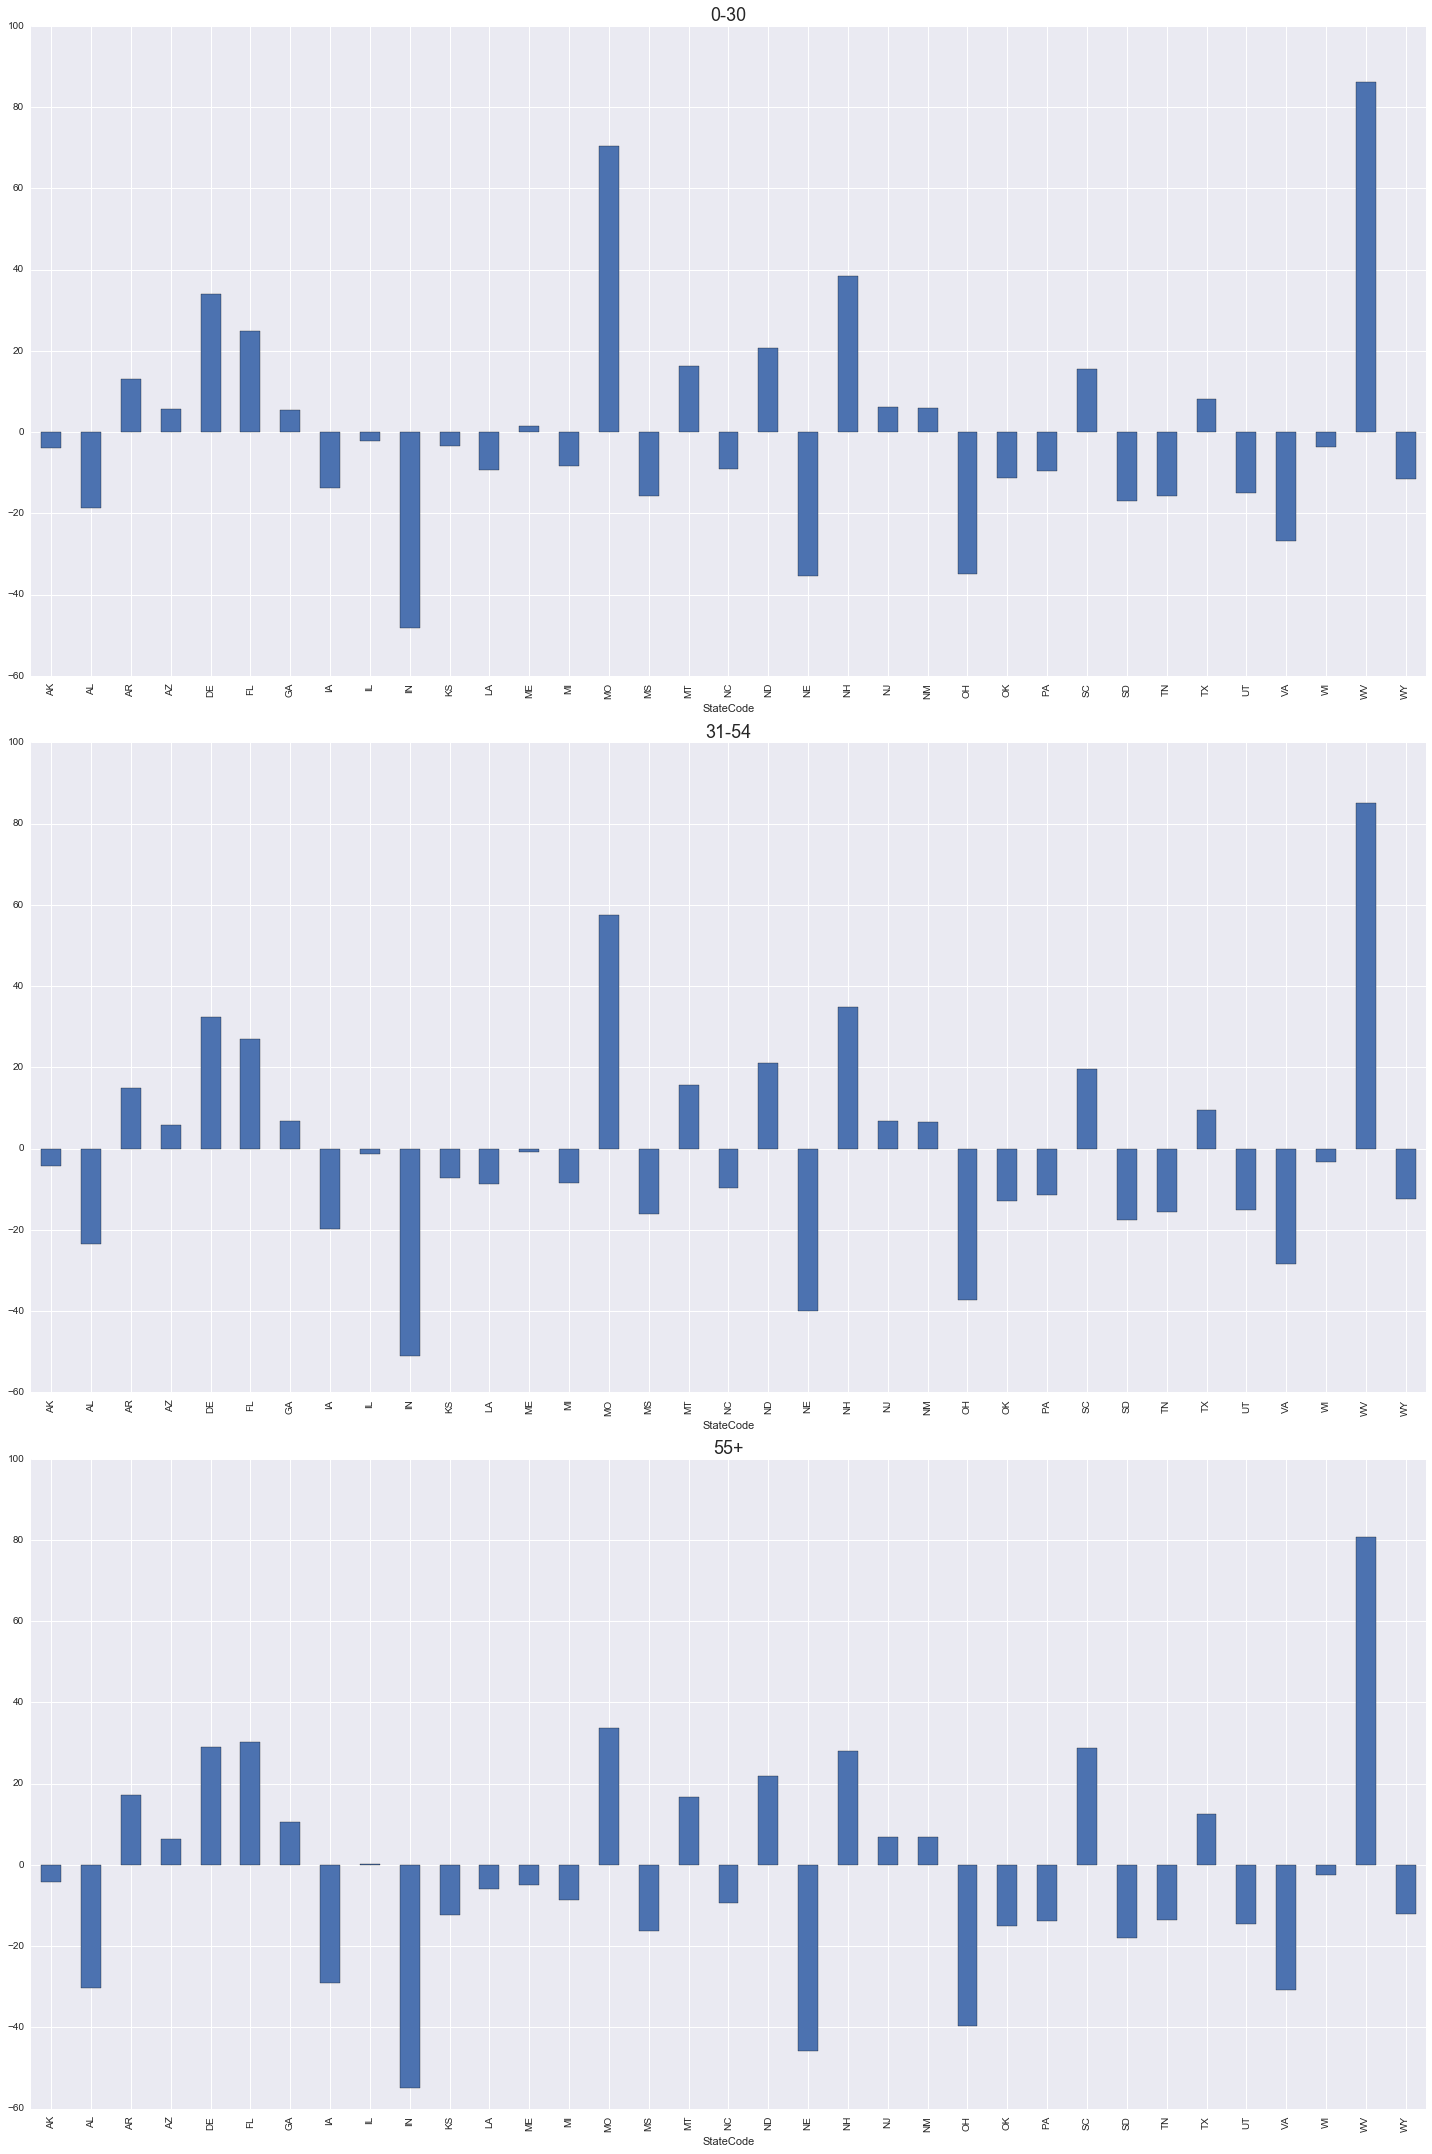

In [331]:
plotChangeByState(change1415)

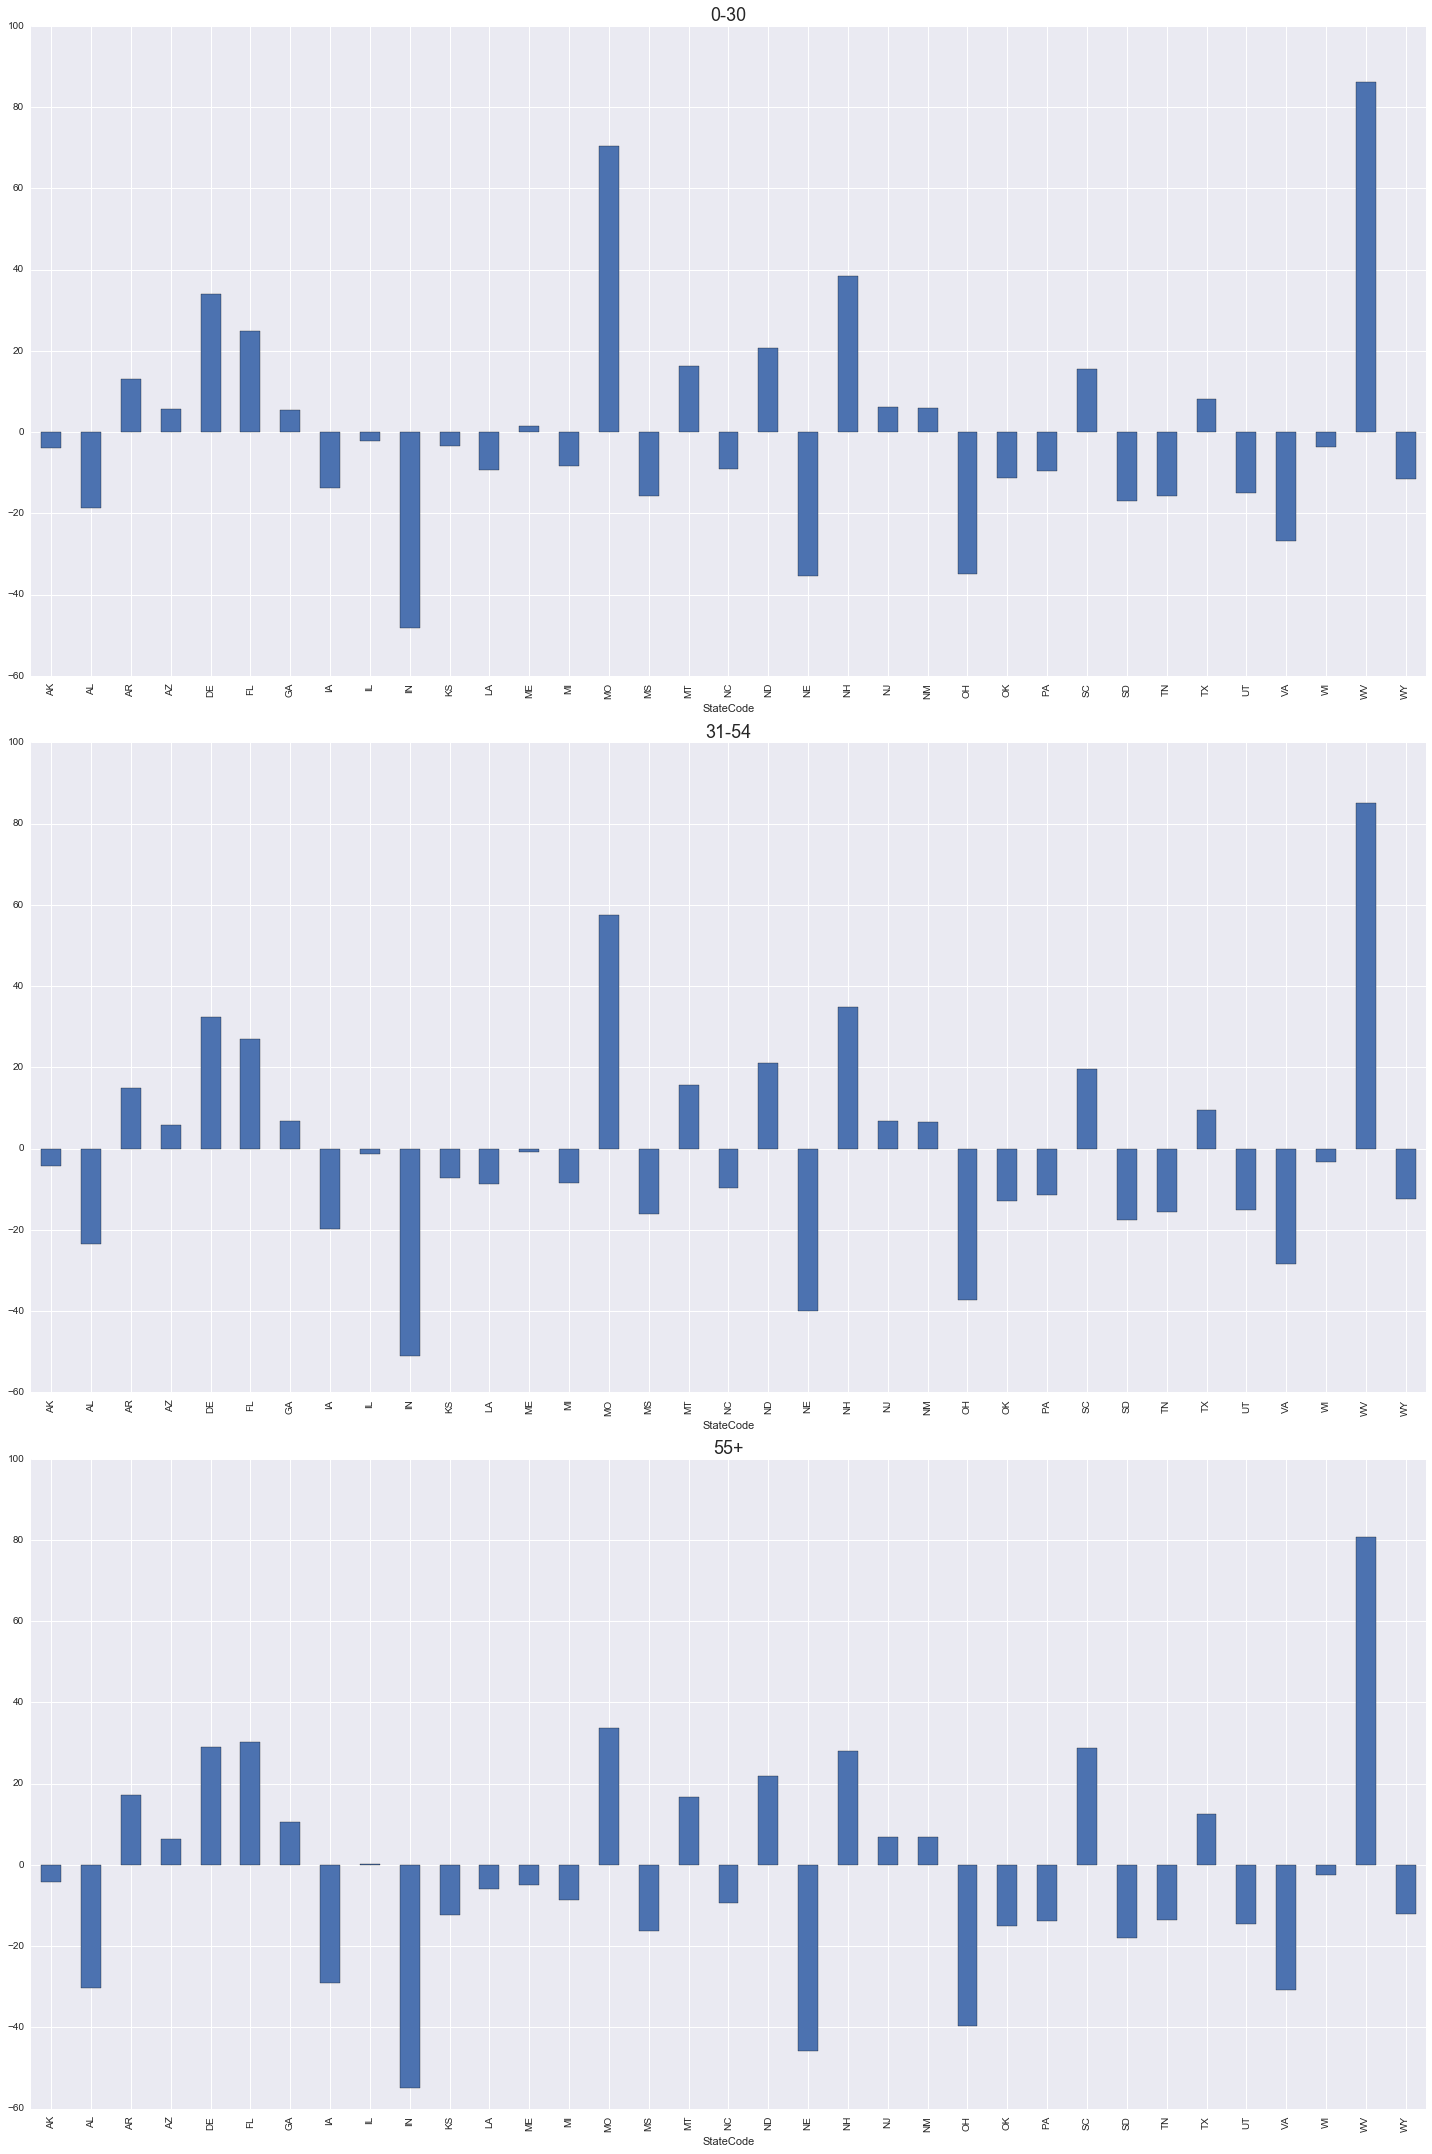

In [332]:
plotChangeByState(change1516)

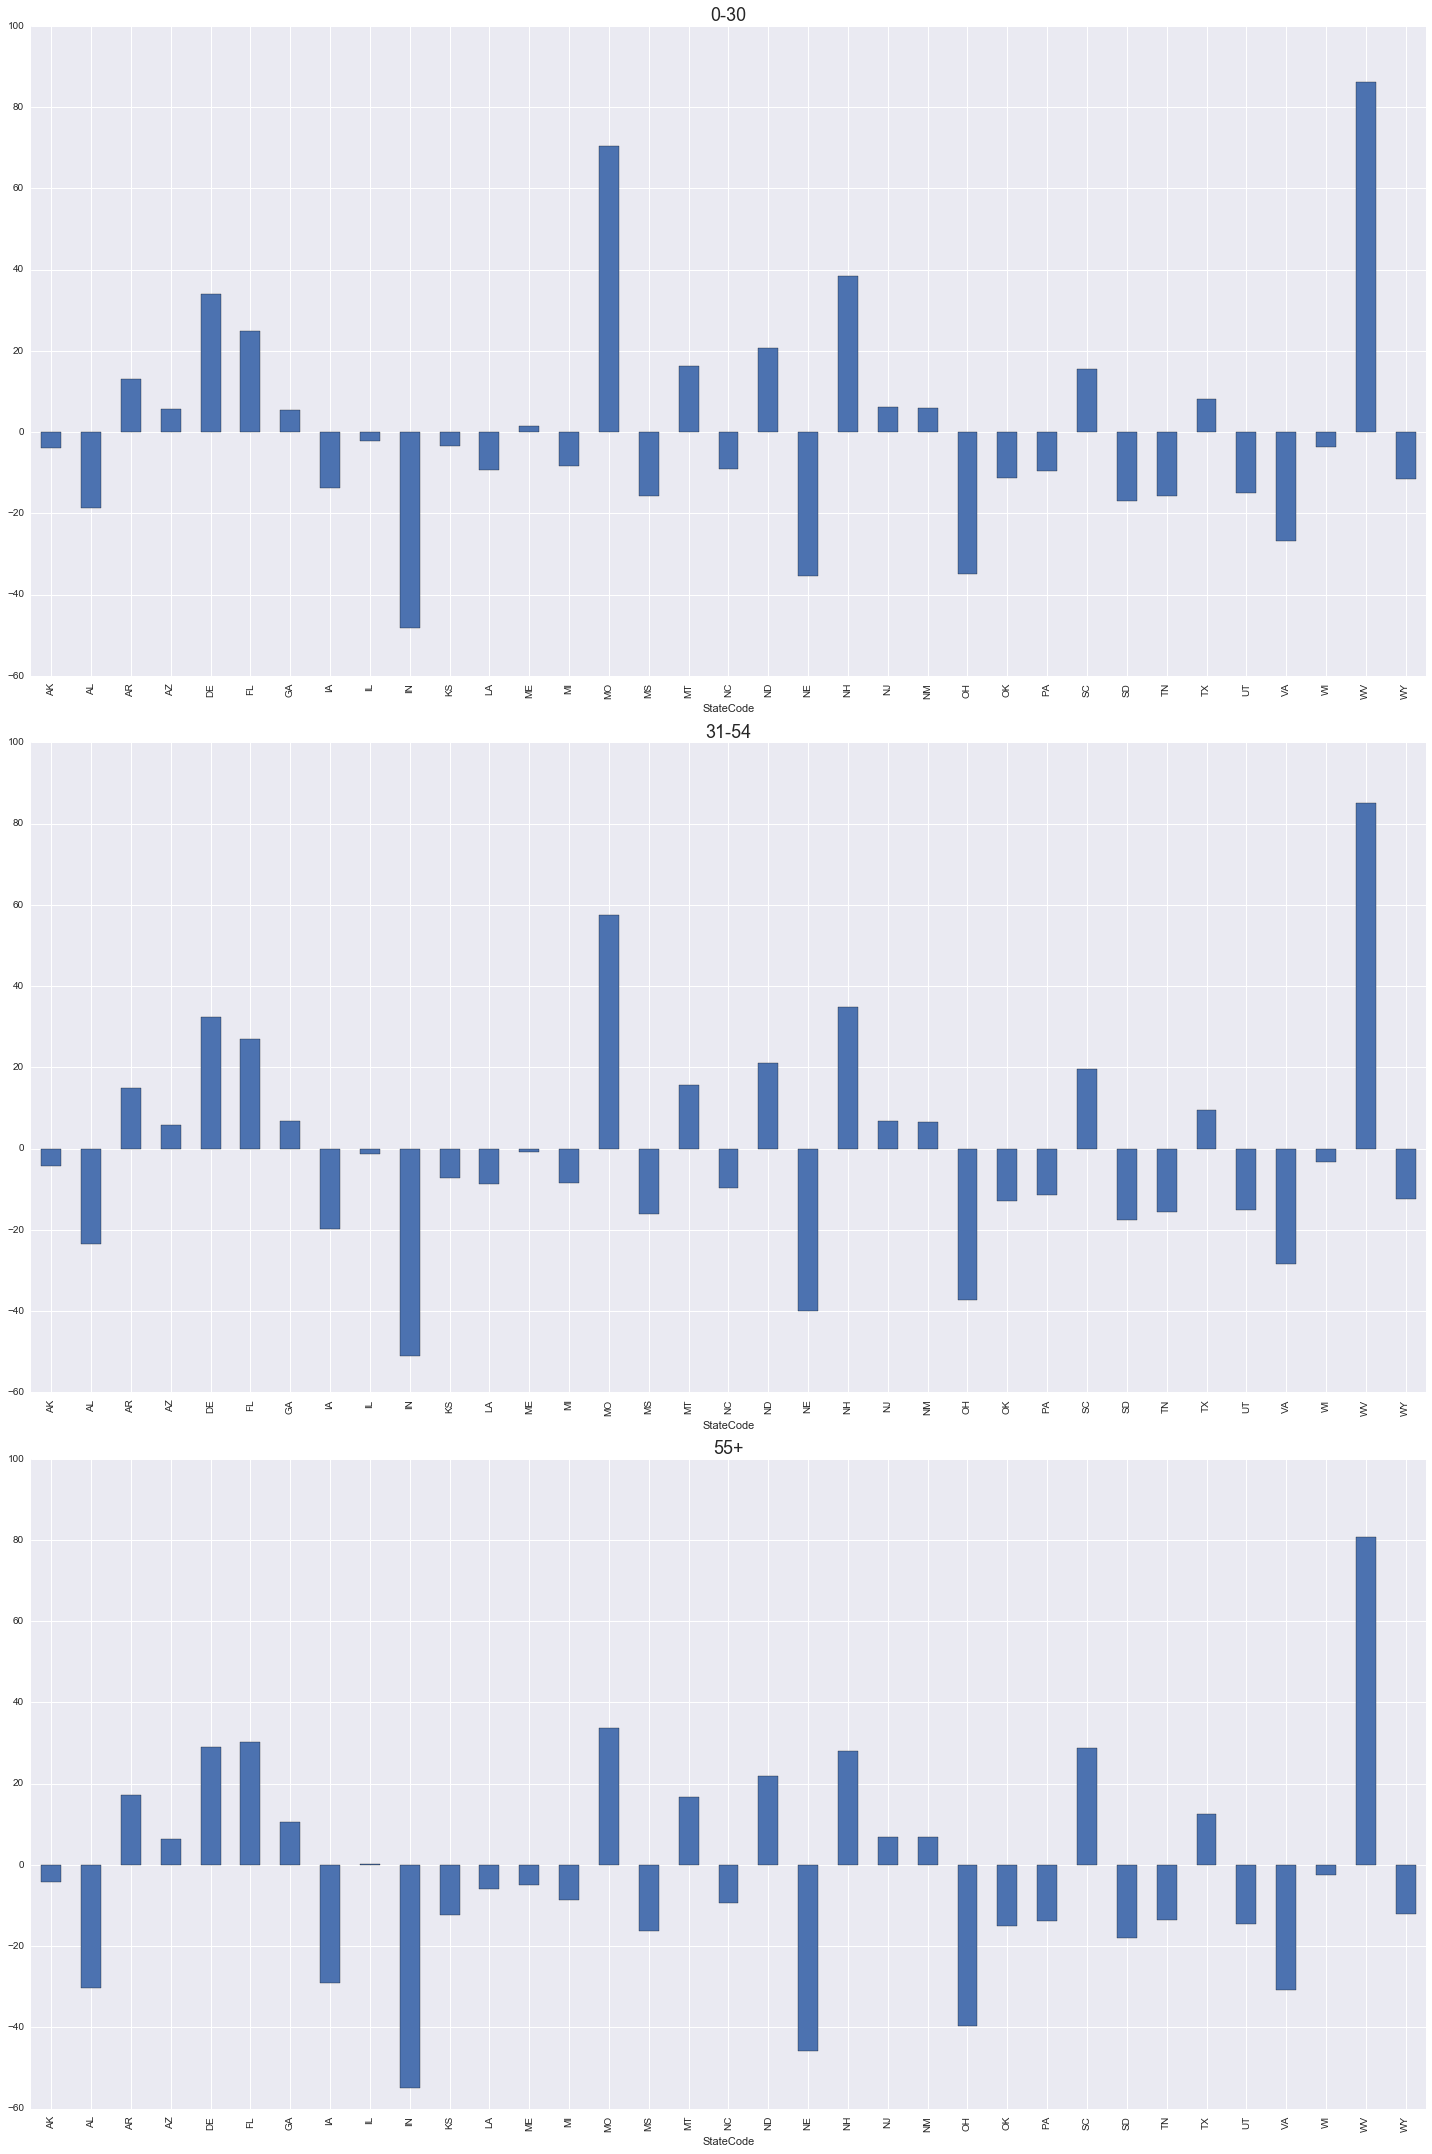

In [333]:
plotChangeByState(change1617)

In [337]:
change1415['years'] = '2014-2015'
change1516['years'] = '2015-2016'
change1617['years'] = '2016-2017'

allYears = pd.concat([change1415, change1516, change1617])


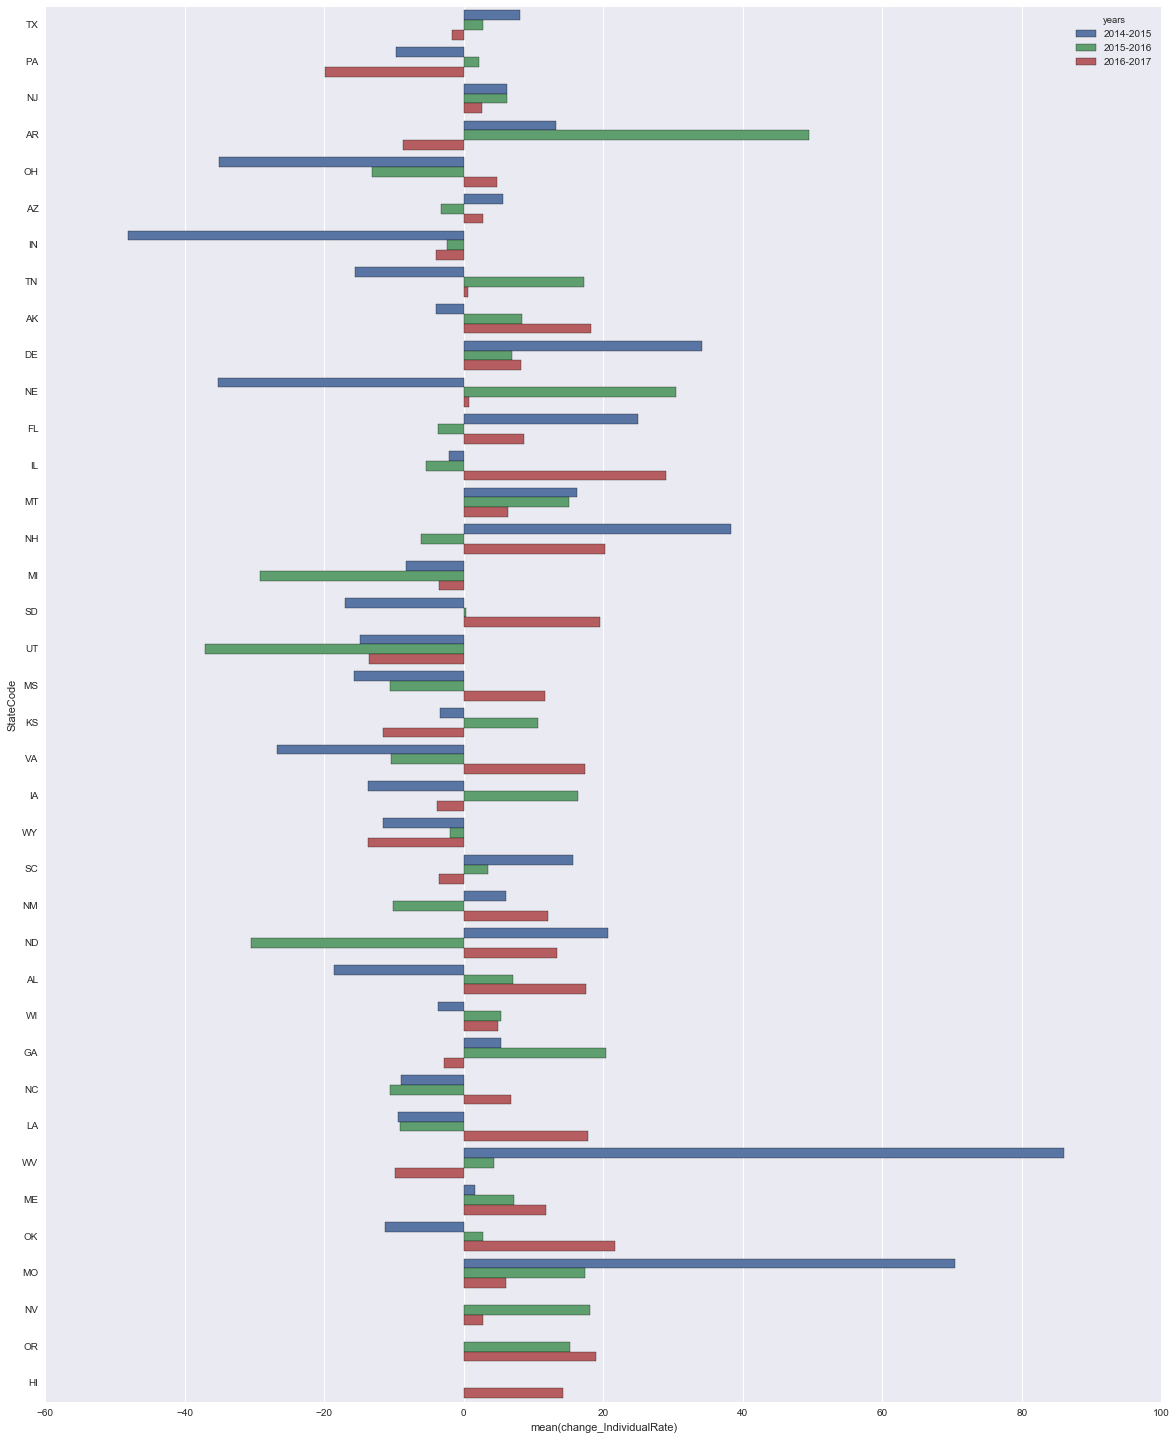

In [353]:
fig, ax =plt.subplots(1,1, figsize=(20, 25))
d = allYears[allYears.ageBin == '0-30']#.groupby(['StateCode', 'years']).change_IndividualRate.mean().reset_index()
sns.barplot(y="StateCode", x='change_IndividualRate', hue='years', ci=None, data=d)
#sns.stripplot(data=d, x='StateCode', y='change_IndividualRate', hue='years' )

## Family Rates

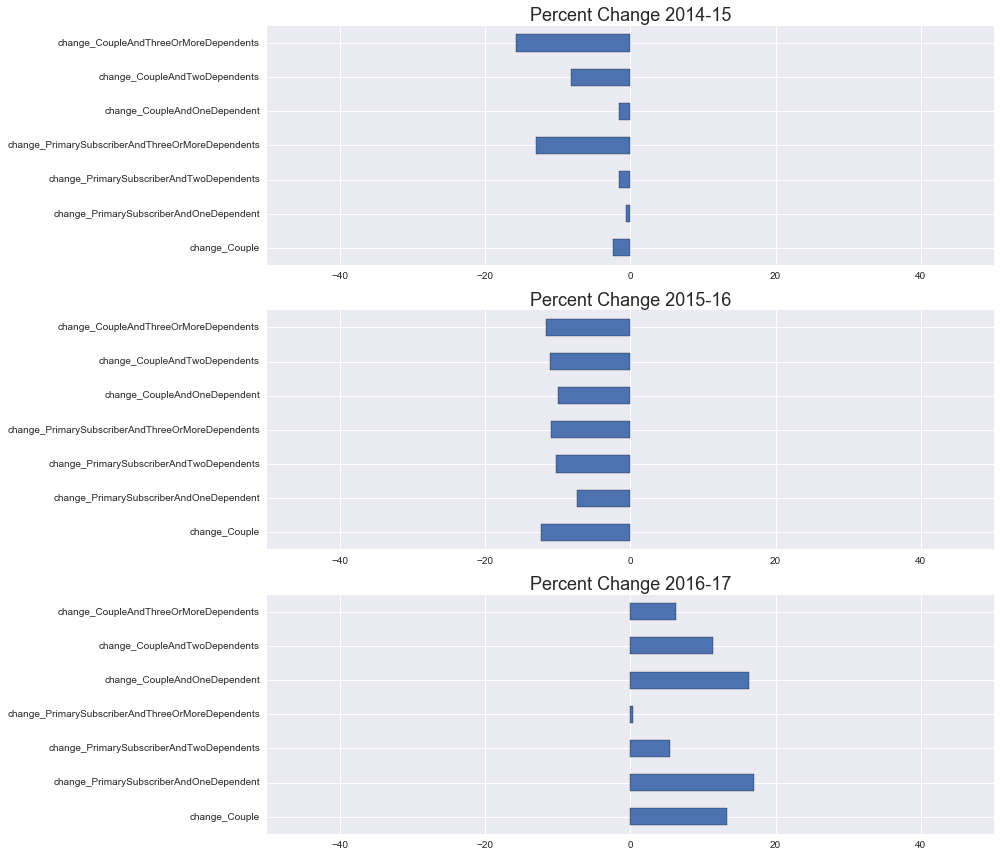

In [75]:
familyCols = ['change_Couple',
       'change_PrimarySubscriberAndOneDependent',
       'change_PrimarySubscriberAndTwoDependents',
       'change_PrimarySubscriberAndThreeOrMoreDependents',
       'change_CoupleAndOneDependent', 'change_CoupleAndTwoDependents',
       'change_CoupleAndThreeOrMoreDependents']

fig, axes = plt.subplots(3,1, figsize=(14,12))
for ax, years, df in zip(axes.ravel(), ['2014-15', '2015-16', '2016-17'], [change1415, change1516, change1617]):
    df[familyCols].mean().plot.barh(ax=ax)
    ax.set_title('Percent Change ' + years)
    ax.set_xlim(-50,50)

fig.tight_layout()

## By State

In [79]:
import folium

In [91]:
fips = pd.read_csv('fips-codes.csv', header=None)

In [132]:
states = pd.DataFrame({'StateCode':pd.Series(fips[0].rename(columns={0:'StateCode'}).unique())})

In [280]:
m = makeStateMap(change1516, 'change_CoupleAndTwoDependents')
m

(31,)


In [210]:
m = makeStateMap(change1617, 'change_Couple')
m

m = makeStateMap(change1415, 'change_Couple')
m

import json
from folium.colormap import linear

us_states =  r'us-states.json'

geo_json_data = json.load(open(us_states))

def makeStateMap(df, dataCol):
    m = folium.Map(location=[43, -100], zoom_start=4)
    
    df = df[df[dataCol].notnull()]
    df = df.merge(states, on='StateCode', how="outer").fillna(-9999)
    print(df.head())
    m.choropleth(
        geo_path=statesJson,
        data=df,
        columns=['StateCode',dataCol],
        key_on='feature.id',
        threshold_scale = [-9999, -9998, -25, 0, 25, 50],
        fill_color='PuBuGn')
    return m